In [3]:
## Celda 1: Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
#Cargar el dataset 
df = pd.read_csv('autos.csv')

selected_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']
df = df[selected_features + ['MPG']]  #MPG es la variable objetivo,son millas por galón de combustible


# Información del dataset
print('=== INFORMACIÓN DEL DATASET ===')
print(f'Tamaño del dataset: {df.shape}')
print(f'\nEstadísticas descriptivas:')
print(df.describe())

=== INFORMACIÓN DEL DATASET ===
Tamaño del dataset: (2000, 7)

Estadísticas descriptivas:
       displacement   horsepower       weight  acceleration         year  \
count   2000.000000  2000.000000  2000.000000   2000.000000  2000.000000   
mean     261.975218   137.335831  3287.368680     15.805436    76.200500   
std      112.501157    53.098701   978.999572      4.597029     3.748376   
min       71.239031    46.002141  1600.104444      8.003856    70.000000   
25%      161.647892    92.144764  2439.579449     11.829282    73.000000   
50%      265.330239   136.655756  3271.136537     15.747181    76.000000   
75%      359.011350   183.759054  4115.496046     19.794138    79.000000   
max      454.891304   229.918617  4997.791022     23.991371    82.000000   

            origin          MPG  
count  2000.000000  2000.000000  
mean      1.996500    46.742194  
std       0.811059     4.939486  
min       1.000000    31.603302  
25%       1.000000    43.344253  
50%       2.000000   

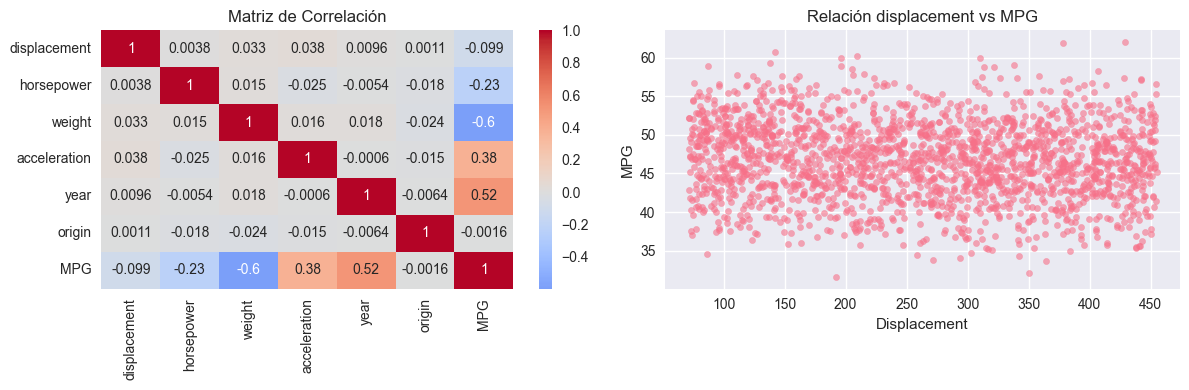

In [5]:
# Visualización de correlaciones
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))

# Matriz de correlación
plt.subplot(1, 2, 1)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')

# Dispersión de una feature contra el target
plt.subplot(1, 2, 2)
plt.scatter(df['displacement'], df['MPG'], alpha=0.6, s=20)
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.title('Relación displacement vs MPG')

plt.tight_layout()
plt.show()


In [6]:
# Celda 3: Preparación de datos para modelado

# Separar características y variable objetivo
X = df.drop('MPG', axis=1)
y = df['MPG']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Estandarización (importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== PREPARACIÓN DE DATOS ===")
print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño prueba: {X_test.shape}")
print(f"Rango de y_train: [{y_train.min():.2f}, {y_train.max():.2f}]")


=== PREPARACIÓN DE DATOS ===
Tamaño entrenamiento: (1600, 6)
Tamaño prueba: (400, 6)
Rango de y_train: [31.60, 62.01]


In [7]:
# Celda 4: Implementación de Regresión Lineal Múltiple
print('=== REGRESIÓN LINEAL MÚLTIPLE ===')


# Entrenar modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

# Métricas
lr_train_mse = mean_squared_error(y_train, y_pred_lr_train)
lr_test_mse = mean_squared_error(y_test, y_pred_lr_test)
lr_train_r2 = r2_score(y_train, y_pred_lr_train)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)

print(f'MSE Entrenamiento: {lr_train_mse:.4f}')
print(f'MSE Prueba: {lr_test_mse:.4f}')
print(f'R² Entrenamiento: {lr_train_r2:.4f}')
print(f'R² Prueba: {lr_test_r2:.4f}')

# Coeficientes
print(f'\nCoeficientes del modelo:')
feature_names = selected_features
for coef, name in zip(lr_model.coef_, feature_names):
    print(f'  {name}: {coef:.4f}')
print(f'  Intercepto: {lr_model.intercept_:.4f}')



=== REGRESIÓN LINEAL MÚLTIPLE ===
MSE Entrenamiento: 3.9270
MSE Prueba: 4.3027
R² Entrenamiento: 0.8388
R² Prueba: 0.8244

Coeficientes del modelo:
  displacement: -0.0045
  horsepower: -0.0200
  weight: -0.0030
  acceleration: 0.4166
  year: 0.6971
  origin: -0.0786
  Intercepto: 1.1607


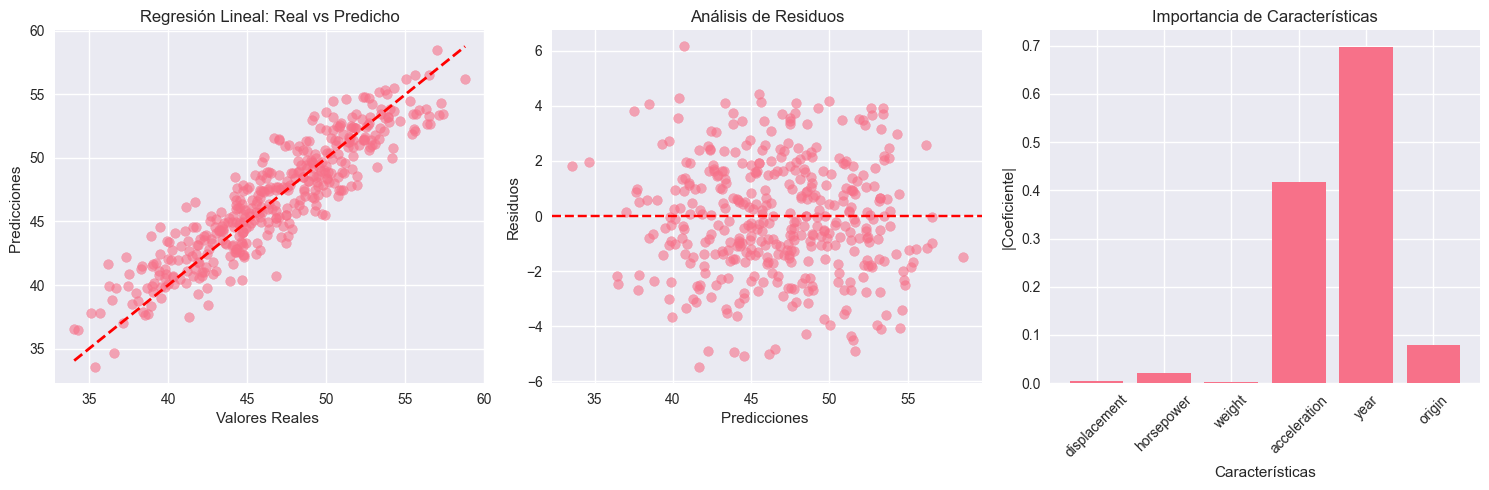

In [8]:
# Celda 5: Análisis de Regresión Lineal

# Visualización de resultados
plt.figure(figsize=(15, 5))

# Gráfico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales ')
plt.ylabel('Predicciones ')
plt.title('Regresión Lineal: Real vs Predicho')

# Gráfico 2: Residuos
plt.subplot(1, 3, 2)
residuals_lr = y_test - y_pred_lr_test
plt.scatter(y_pred_lr_test, residuals_lr, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones ')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')

# Gráfico 3: Importancia de características (coeficientes)
plt.subplot(1, 3, 3)
feature_names = selected_features
feature_importance = abs(lr_model.coef_)
plt.bar(feature_names, feature_importance)
plt.xlabel('Características')
plt.ylabel('|Coeficiente|')
plt.title('Importancia de Características')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [9]:
# Celda 6: Implementación de Árbol de Regresión
# Entrenar modelo con diferentes profundidades para encontrar la óptima
depths = [3, 5, 7, 10, 15, 20]
best_depth = 0
best_score = float('-inf')

for depth in depths:
    tree_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_temp, X_train, y_train, cv=5, scoring='r2')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_depth = depth

print(f"Mejor profundidad encontrada: {best_depth}")        
# Entrenar modelo final
tree_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_tree_train = tree_model.predict(X_train)
y_pred_tree_test = tree_model.predict(X_test)

# Métricas
tree_train_mse = mean_squared_error(y_train, y_pred_tree_train)
tree_test_mse = mean_squared_error(y_test, y_pred_tree_test)
tree_train_r2 = r2_score(y_train, y_pred_tree_train)
tree_test_r2 = r2_score(y_test, y_pred_tree_test)

print(f"MSE Entrenamiento: {tree_train_mse:.4f}")
print(f"MSE Prueba: {tree_test_mse:.4f}")
print(f"R² Entrenamiento: {tree_train_r2:.4f}")
print(f"R² Prueba: {tree_test_r2:.4f}")

Mejor profundidad encontrada: 7
MSE Entrenamiento: 3.2804
MSE Prueba: 8.5879
R² Entrenamiento: 0.8653
R² Prueba: 0.6496


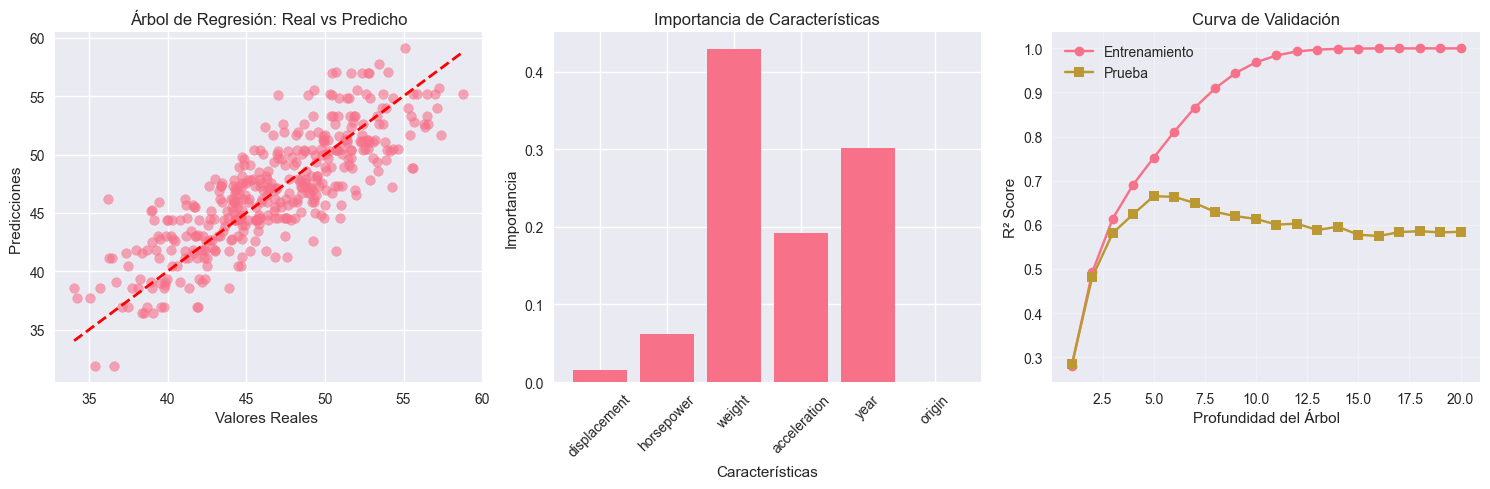

In [10]:
# Celda 7: Análisis de Árbol de Regresión
# Visualización de resultados
plt.figure(figsize=(15, 5))

# Gráfico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_tree_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales ')
plt.ylabel('Predicciones ')
plt.title('Árbol de Regresión: Real vs Predicho')

# Gráfico 2: Importancia de características
plt.subplot(1, 3, 2)
feature_names = selected_features
feature_importance = tree_model.feature_importances_
plt.bar(feature_names, feature_importance)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de Características')
plt.xticks(rotation=45)

# Gráfico 3: Análisis de profundidad
plt.subplot(1, 3, 3)
depths_analysis = range(1, 21)
train_scores = []
test_scores = []

for depth in depths_analysis:
    tree_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_temp.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, tree_temp.predict(X_train)))
    test_scores.append(r2_score(y_test, tree_temp.predict(X_test)))

plt.plot(depths_analysis, train_scores, label='Entrenamiento', marker='o')
plt.plot(depths_analysis, test_scores, label='Prueba', marker='s')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('R² Score')
plt.title('Curva de Validación')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
## Celda 8: Implementación de Red Neuronal
print("=== RED NEURONAL (MLP) ===")


# Probar diferentes arquitecturas
architectures = [
    (50,), (100,), (50, 25), (100, 50), (100, 50, 25)
]

best_architecture = None
best_score = float('-inf')


for arch in architectures:
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=arch,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
    scores = cross_val_score(mlp_temp, X_train_scaled, y_train, cv=3, scoring='r2')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_architecture = arch


print(f"Mejor arquitectura encontrada: {best_architecture}")

# Entrenar modelo final
mlp_model = MLPRegressor(
    hidden_layer_sizes=best_architecture,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_mlp_train = mlp_model.predict(X_train_scaled)
y_pred_mlp_test = mlp_model.predict(X_test_scaled)

# Métricas
mlp_train_mse = mean_squared_error(y_train, y_pred_mlp_train)
mlp_test_mse = mean_squared_error(y_test, y_pred_mlp_test)
mlp_train_r2 = r2_score(y_train, y_pred_mlp_train)
mlp_test_r2 = r2_score(y_test, y_pred_mlp_test)

print(f"MSE Entrenamiento: {mlp_train_mse:.4f}")
print(f"MSE Prueba: {mlp_test_mse:.4f}")
print(f"R² Entrenamiento: {mlp_train_r2:.4f}")
print(f"R² Prueba: {mlp_test_r2:.4f}")
print(f"Número de iteraciones: {mlp_model.n_iter_}")



=== RED NEURONAL (MLP) ===
Mejor arquitectura encontrada: (50, 25)
MSE Entrenamiento: 3.8174
MSE Prueba: 4.8723
R² Entrenamiento: 0.8433
R² Prueba: 0.8012
Número de iteraciones: 338


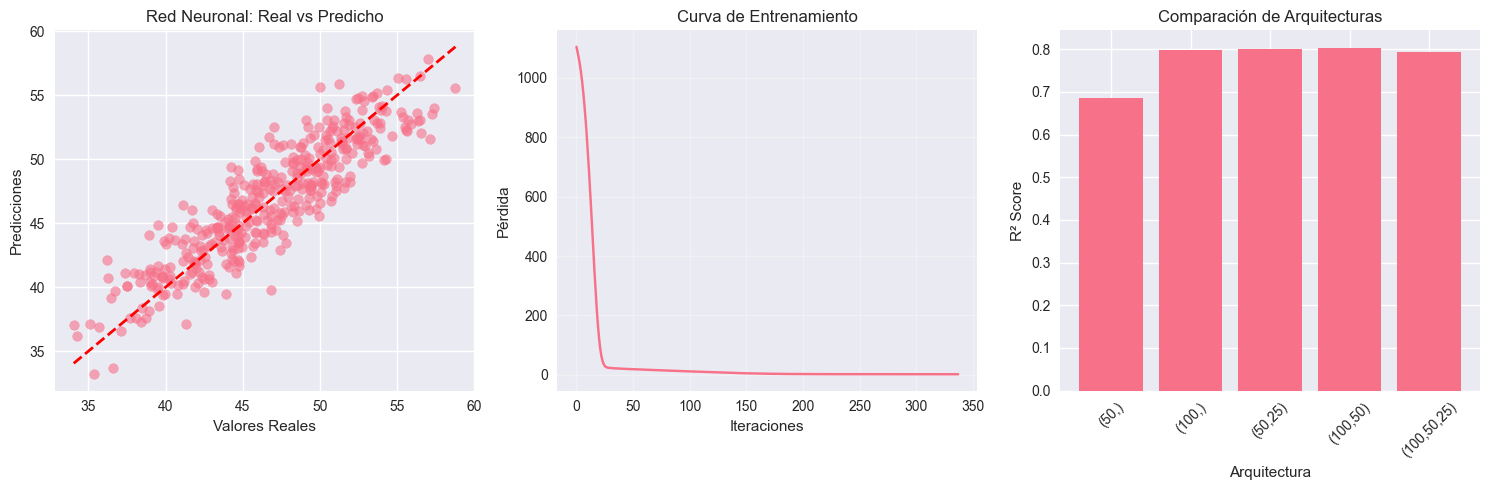

In [12]:
## Celda 9: Análisis de Red Neuronal
# Visualización de resultados
plt.figure(figsize=(15, 5))

# Gráfico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_mlp_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Red Neuronal: Real vs Predicho')

# Gráfico 2: Curva de pérdida
plt.subplot(1, 3, 2)
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.title('Curva de Entrenamiento')
plt.grid(True, alpha=0.3)


# Gráfico 3: Comparación de arquitecturas
plt.subplot(1, 3, 3)
arch_names = ['(50,)', '(100,)', '(50,25)', '(100,50)', '(100,50,25)']
arch_scores = []
for arch in architectures:
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=arch,
        max_iter=500,
        random_state=42
    )
    mlp_temp.fit(X_train_scaled, y_train)
    score = r2_score(y_test, mlp_temp.predict(X_test_scaled))
    arch_scores.append(score)

plt.bar(arch_names, arch_scores)
plt.xlabel('Arquitectura')
plt.ylabel('R² Score')
plt.title('Comparación de Arquitecturas')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [13]:
## Celda 10: Comparación de Rendimiento
print("=== COMPARACIÓN DE MÉTODOS ===")

# Crear tabla de comparación
models = ['Regresión Lineal', 'Árbol de Regresión', 'Red Neuronal']
train_mse = [lr_train_mse, tree_train_mse, mlp_train_mse]
test_mse = [lr_test_mse, tree_test_mse, mlp_test_mse]
train_r2 = [lr_train_r2, tree_train_r2, mlp_train_r2]
test_r2 = [lr_test_r2, tree_test_r2, mlp_test_r2]


# Calcular MAE adicional
lr_mae = mean_absolute_error(y_test, y_pred_lr_test)
tree_mae = mean_absolute_error(y_test, y_pred_tree_test)
mlp_mae = mean_absolute_error(y_test, y_pred_mlp_test)
test_mae = [lr_mae, tree_mae, mlp_mae]


comparison_df = pd.DataFrame({
    'Modelo': models,
    'MSE_Train': train_mse,
    'MSE_Test': test_mse,
    'R²_Train': train_r2,
    'R²_Test': test_r2,
    'MAE_Test': test_mae
})



print(comparison_df.round(4))


# Identificar mejor modelo
best_model_idx = np.argmax(test_r2)
print(f"\nMejor modelo por R² en prueba: {models[best_model_idx]}")
print(f"R² = {test_r2[best_model_idx]:.4f}")

=== COMPARACIÓN DE MÉTODOS ===
               Modelo  MSE_Train  MSE_Test  R²_Train  R²_Test  MAE_Test
0    Regresión Lineal     3.9270    4.3027    0.8388   0.8244    1.6855
1  Árbol de Regresión     3.2804    8.5879    0.8653   0.6496    2.3615
2        Red Neuronal     3.8174    4.8723    0.8433   0.8012    1.7956

Mejor modelo por R² en prueba: Regresión Lineal
R² = 0.8244


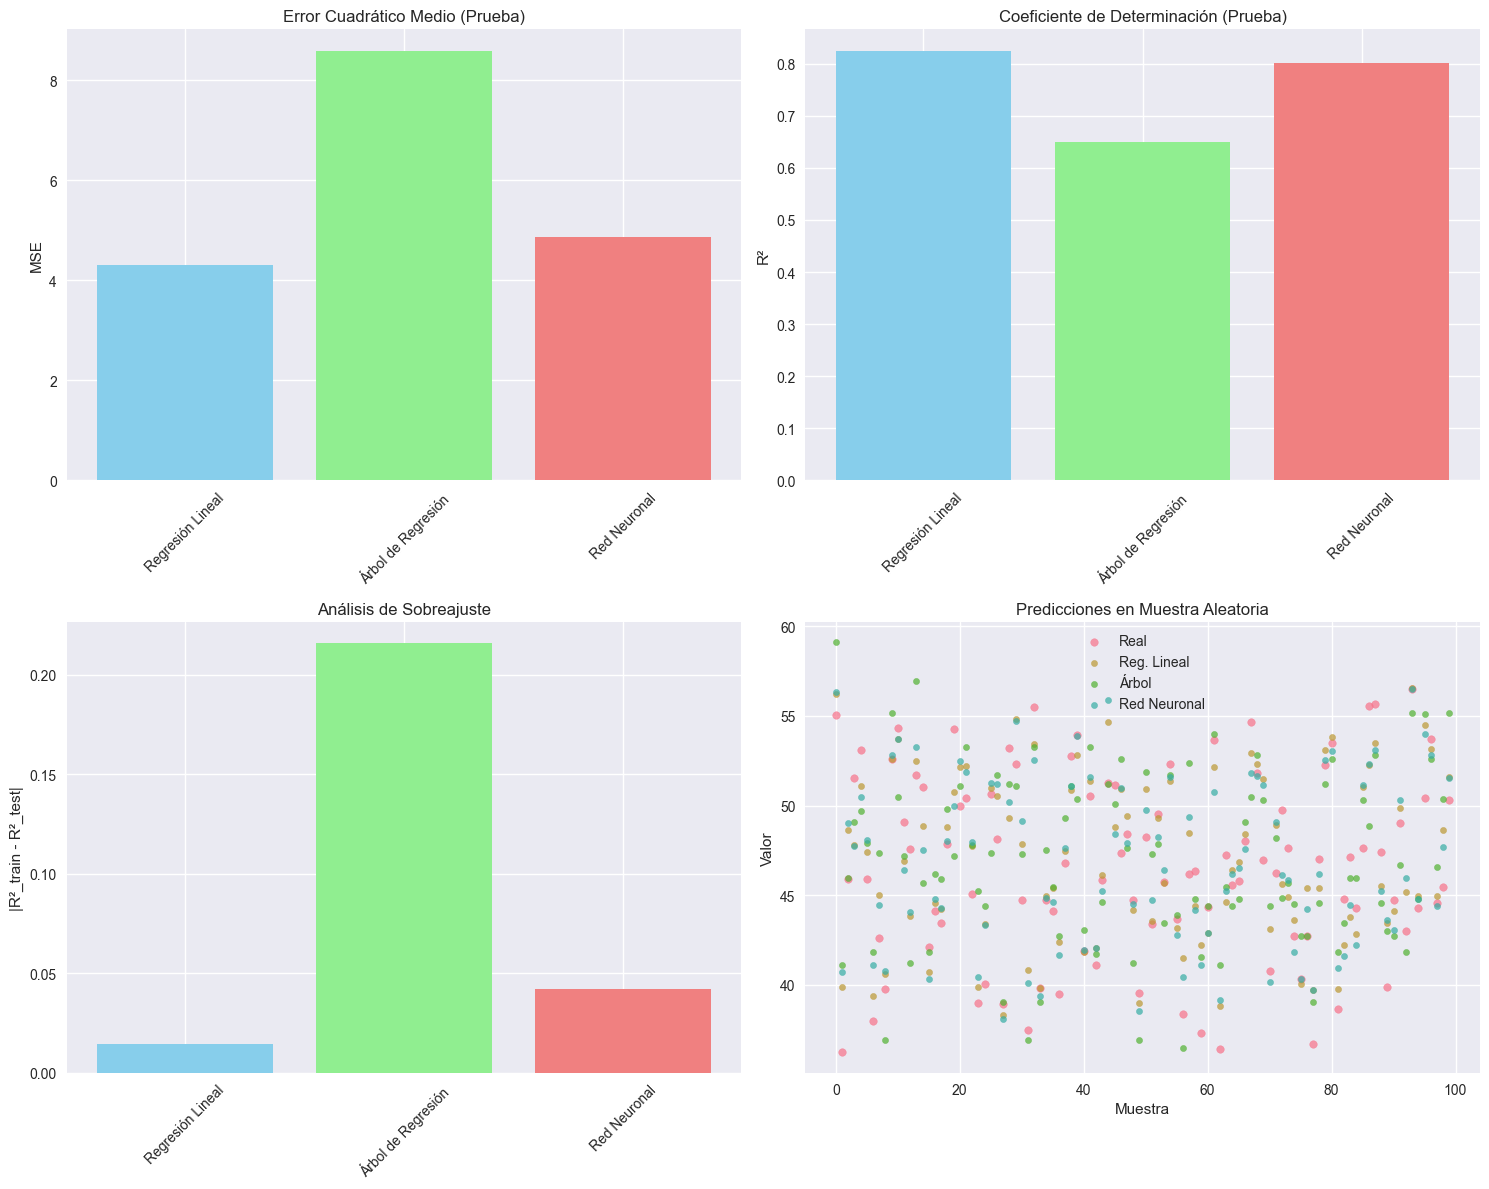

In [14]:
## Celda 11: Visualización Comparativa
# Gráficos de comparación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: MSE Comparación
axes[0, 0].bar(models, test_mse, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_title('Error Cuadrático Medio (Prueba)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: R² Comparación
axes[0, 1].bar(models, test_r2, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_ylabel('R²')
axes[0, 1].set_title('Coeficiente de Determinación (Prueba)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Gráfico 3: Overfitting análisis
overfitting = [abs(train_r2[i] - test_r2[i]) for i in range(3)]
axes[1, 0].bar(models, overfitting, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 0].set_ylabel('|R²_train - R²_test|')
axes[1, 0].set_title('Análisis de Sobreajuste')
axes[1, 0].tick_params(axis='x', rotation=45)


# Gráfico 4: Predicciones comparativas
sample_indices = np.random.choice(len(y_test), 100, replace=False)
x_pos = np.arange(len(sample_indices))

axes[1, 1].scatter(x_pos, y_test.iloc[sample_indices], alpha=0.7, label='Real', s=30)
axes[1, 1].scatter(x_pos, y_pred_lr_test[sample_indices], alpha=0.7, label='Reg. Lineal', s=20)
axes[1, 1].scatter(x_pos, y_pred_tree_test[sample_indices], alpha=0.7, label='Árbol', s=20)
axes[1, 1].scatter(x_pos, y_pred_mlp_test[sample_indices], alpha=0.7, label='Red Neuronal', s=20)
axes[1, 1].set_xlabel('Muestra')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].set_title('Predicciones en Muestra Aleatoria')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

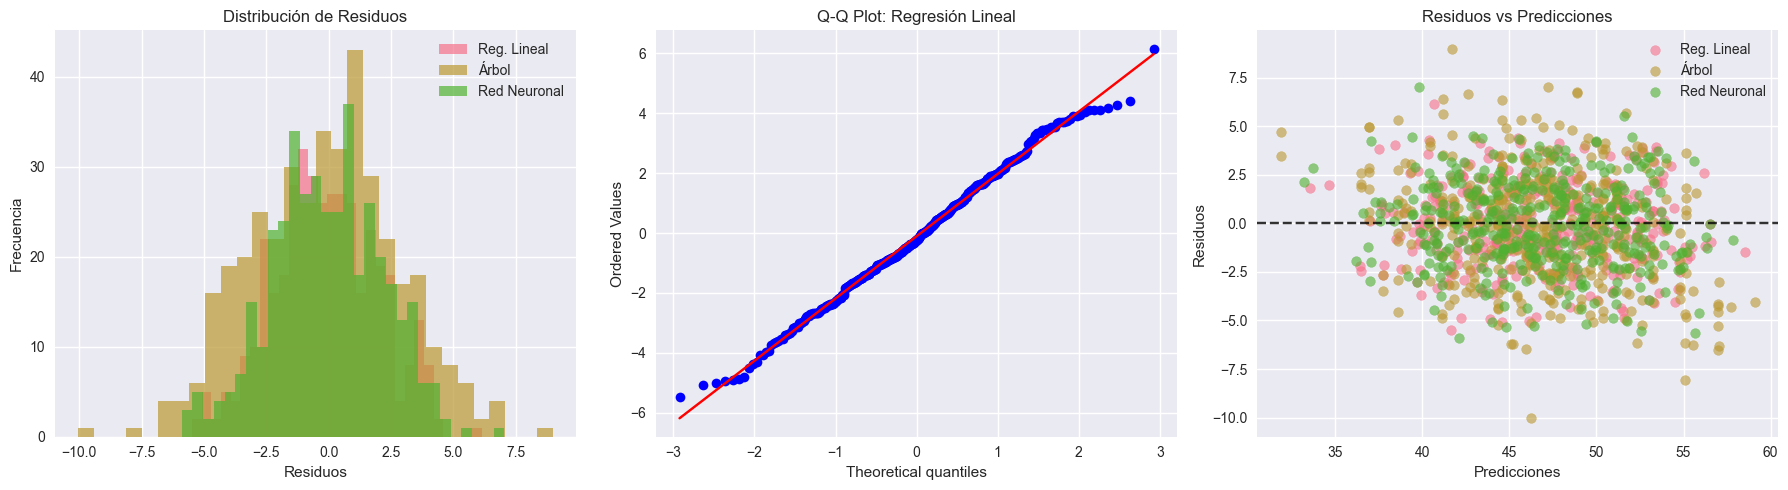

In [15]:
## Celda 12: Análisis de Residuos Comparativo
# Análisis detallado de residuos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuos de cada modelo
residuals_lr = y_test - y_pred_lr_test
residuals_tree = y_test - y_pred_tree_test
residuals_mlp = y_test - y_pred_mlp_test

# Histogramas de residuos
axes[0].hist(residuals_lr, bins=30, alpha=0.7, label='Reg. Lineal')
axes[0].hist(residuals_tree, bins=30, alpha=0.7, label='Árbol')
axes[0].hist(residuals_mlp, bins=30, alpha=0.7, label='Red Neuronal')
axes[0].set_xlabel('Residuos')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Residuos')
axes[0].legend()

# Q-Q plot para normalidad (solo regresión lineal)
from scipy import stats
stats.probplot(residuals_lr, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Regresión Lineal')

# Residuos vs predicciones
axes[2].scatter(y_pred_lr_test, residuals_lr, alpha=0.6, label='Reg. Lineal')
axes[2].scatter(y_pred_tree_test, residuals_tree, alpha=0.6, label='Árbol')
axes[2].scatter(y_pred_mlp_test, residuals_mlp, alpha=0.6, label='Red Neuronal')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.8)
axes[2].set_xlabel('Predicciones')
axes[2].set_ylabel('Residuos')
axes[2].set_title('Residuos vs Predicciones')
axes[2].legend()

plt.tight_layout()
plt.show()

=== ANÁLISIS POR SEGMENTOS ===
  Segmento  Tamaño  Reg_Lineal_R2  Arbol_R2  Red_Neuronal_R2
0     Bajo     133         0.2997   -0.2935           0.2494
1    Medio     134        -0.9983   -2.4371          -1.3217
2     Alto     133         0.1093   -1.1583          -0.0394


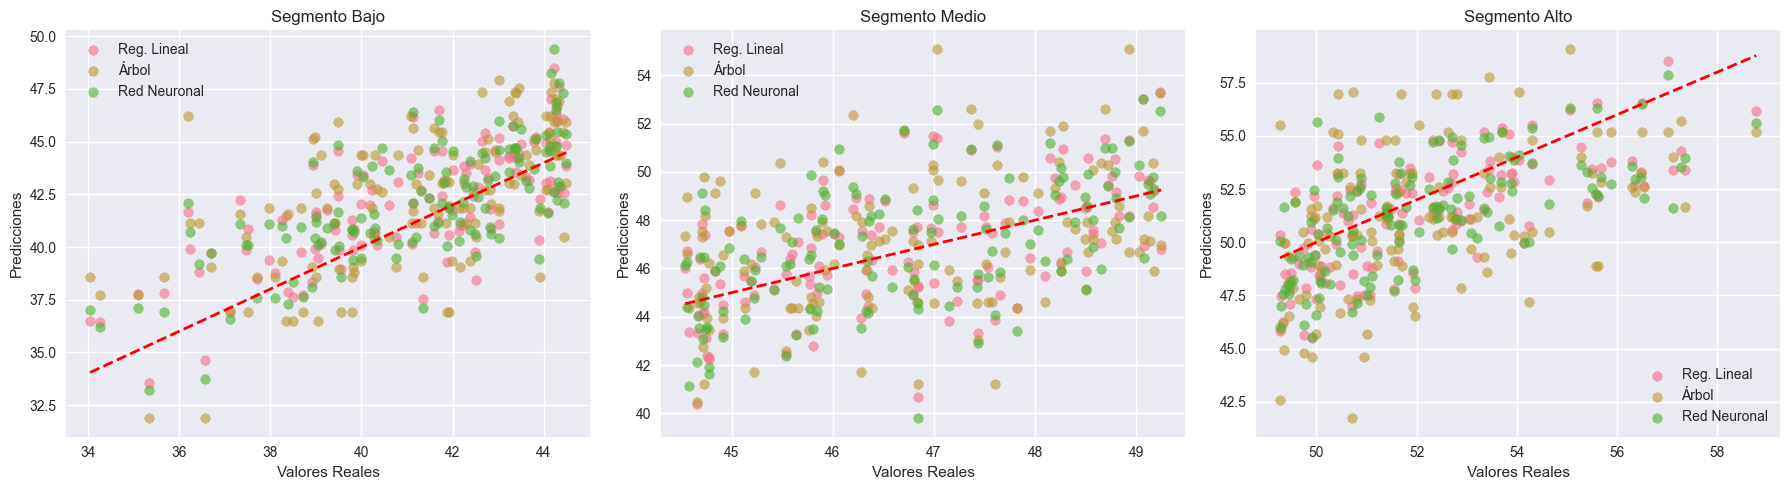

In [16]:
## Celda 13: Análisis de Segmentos de Datos
# Análisis por rangos de la variable objetivo
print("=== ANÁLISIS POR SEGMENTOS ===")

# Dividir datos en terciles
y_test_array = y_test.values
terciles = np.percentile(y_test_array, [33.33, 66.67])
low_mask = y_test_array < terciles[0]
mid_mask = (y_test_array >= terciles[0]) & (y_test_array < terciles[1])
high_mask = y_test_array >= terciles[1]

segments = ['Bajo', 'Medio', 'Alto']
masks = [low_mask, mid_mask, high_mask]


# Calcular métricas por segmento
segment_results = []
for i, mask in enumerate(masks):
    if np.sum(mask) > 0:
        lr_r2 = r2_score(y_test_array[mask], y_pred_lr_test[mask])
        tree_r2 = r2_score(y_test_array[mask], y_pred_tree_test[mask])
        mlp_r2 = r2_score(y_test_array[mask], y_pred_mlp_test[mask])
        
        segment_results.append({
            'Segmento': segments[i],
            'Tamaño': np.sum(mask),
            'Reg_Lineal_R2': lr_r2,
            'Arbol_R2': tree_r2,
            'Red_Neuronal_R2': mlp_r2
        })


segment_df = pd.DataFrame(segment_results)
print(segment_df.round(4))


# Visualización por segmentos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (segment, mask) in enumerate(zip(segments, masks)):
    if np.sum(mask) > 0:
        axes[i].scatter(y_test_array[mask], y_pred_lr_test[mask], alpha=0.6, label='Reg. Lineal')
        axes[i].scatter(y_test_array[mask], y_pred_tree_test[mask], alpha=0.6, label='Árbol')
        axes[i].scatter(y_test_array[mask], y_pred_mlp_test[mask], alpha=0.6, label='Red Neuronal')
        axes[i].plot([y_test_array[mask].min(), y_test_array[mask].max()], 
                    [y_test_array[mask].min(), y_test_array[mask].max()], 'r--', lw=2)
        axes[i].set_xlabel('Valores Reales')
        axes[i].set_ylabel('Predicciones')
        axes[i].set_title(f'Segmento {segment}')
        axes[i].legend()

plt.tight_layout()
plt.show()

In [17]:
## Celda 14: Validación Cruzada Completa
print("=== VALIDACIÓN CRUZADA COMPLETA ===")

from sklearn.model_selection import cross_validate

# Definir métricas para evaluación
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Validación cruzada para cada modelo
models_cv = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Regresión': DecisionTreeRegressor(max_depth=best_depth, random_state=42),
    'Red Neuronal': MLPRegressor(hidden_layer_sizes=best_architecture, max_iter=500, random_state=42)
}

cv_results = {}
for name, model in models_cv.items():
    if name == 'Red Neuronal':
        # Para red neuronal usar datos escalados
        scores = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scoring)
    else:
        scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    
    cv_results[name] = {
        'R2': scores['test_r2'].mean(),
        'R2_std': scores['test_r2'].std(),
        'MSE': -scores['test_neg_mean_squared_error'].mean(),
        'MSE_std': scores['test_neg_mean_squared_error'].std(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'MAE_std': scores['test_neg_mean_absolute_error'].std()
    }


# Mostrar resultados
cv_df = pd.DataFrame(cv_results).T
print("Resultados de Validación Cruzada (5-fold):")
print(cv_df.round(4))

=== VALIDACIÓN CRUZADA COMPLETA ===
Resultados de Validación Cruzada (5-fold):
                        R2  R2_std     MSE  MSE_std     MAE  MAE_std
Regresión Lineal    0.8363  0.0225  3.9591   0.4025  1.5828   0.0876
Árbol de Regresión  0.6584  0.0391  8.2669   0.6480  2.2962   0.0904
Red Neuronal        0.8168  0.0248  4.4290   0.4184  1.6915   0.0980


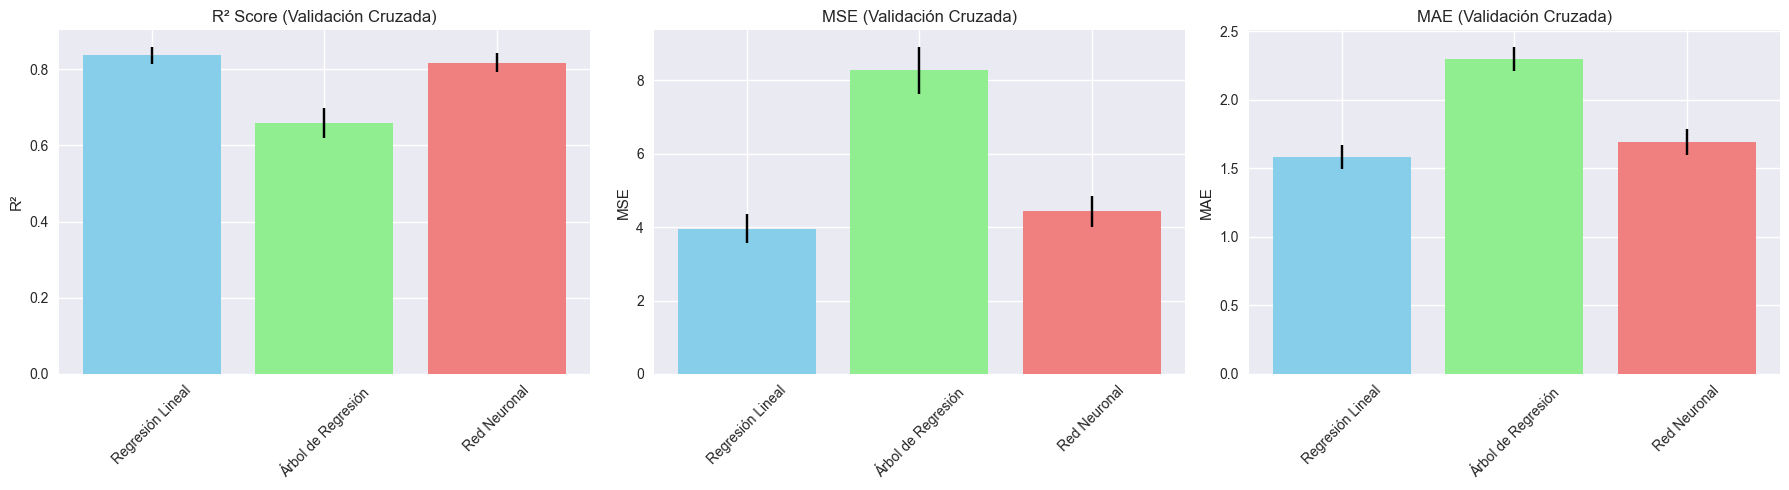

In [18]:
# Gráfico de barras con intervalos de confianza
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_names = list(cv_results.keys())
r2_means = [cv_results[name]['R2'] for name in models_names]
r2_stds = [cv_results[name]['R2_std'] for name in models_names]

mse_means = [cv_results[name]['MSE'] for name in models_names]
mse_stds = [cv_results[name]['MSE_std'] for name in models_names]

# R² con intervalos de confianza
axes[0].bar(models_names, r2_means, yerr=r2_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_ylabel('R²')
axes[0].set_title('R² Score (Validación Cruzada)')
axes[0].tick_params(axis='x', rotation=45)

# MSE con intervalos de confianza
axes[1].bar(models_names, mse_means, yerr=mse_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE (Validación Cruzada)')
axes[1].tick_params(axis='x', rotation=45)

# Calcular MAE y su desviación estándar
mae_means = [cv_results[name]['MAE'] for name in models_names]
mae_stds = [cv_results[name]['MAE_std'] for name in models_names]

# MAE con intervalos de confianza
axes[2].bar(models_names, mae_means, yerr=mae_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE (Validación Cruzada)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [19]:
## Celda 15: Conclusiones y Recomendaciones
print("=== CONCLUSIONES Y RECOMENDACIONES ===")

# Resumen final
print("\n📊 RESUMEN EJECUTIVO:")
print("="*50)

# Mejor modelo general
best_cv_model = max(cv_results.keys(), key=lambda x: cv_results[x]['R2'])
print(f"🏆 Mejor modelo (Validación Cruzada): {best_cv_model}")
print(f"   R² = {cv_results[best_cv_model]['R2']:.4f} ± {cv_results[best_cv_model]['R2_std']:.4f}")

# Análisis de complejidad vs rendimiento
print(f"\n📈 ANÁLISIS DE RENDIMIENTO:")
print(f"• Regresión Lineal: Simple, interpretable, R² = {cv_results['Regresión Lineal']['R2']:.4f}")
print(f"• Árbol de Regresión: Captura no-linealidades, R² = {cv_results['Árbol de Regresión']['R2']:.4f}")
print(f"• Red Neuronal: Más compleja, R² = {cv_results['Red Neuronal']['R2']:.4f}")

=== CONCLUSIONES Y RECOMENDACIONES ===

📊 RESUMEN EJECUTIVO:
🏆 Mejor modelo (Validación Cruzada): Regresión Lineal
   R² = 0.8363 ± 0.0225

📈 ANÁLISIS DE RENDIMIENTO:
• Regresión Lineal: Simple, interpretable, R² = 0.8363
• Árbol de Regresión: Captura no-linealidades, R² = 0.6584
• Red Neuronal: Más compleja, R² = 0.8168
